<a href="https://colab.research.google.com/github/ztutar/HDA_Project/blob/main/BoneAgePredictionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ztutar/HDA_Project.git

Cloning into 'HDA_Project'...
remote: Enumerating objects: 693, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 693 (delta 123), reused 200 (delta 88), pack-reused 445 (from 1)
Receiving objects: 100% (693/693), 42.81 MiB | 13.58 MiB/s, done.
Resolving deltas: 100% (316/316), done.


In [ ]:
cd HDA_Project/

/content/HDA_Project


In [ ]:
!pip -q install e .

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Import necessary libraries
import tensorflow as tf
import keras
import pandas as pd
import os
from keras import optimizers, losses, callbacks, metrics
import time

from BAP.utils.dataset_loader import (
    get_rsna_dataset, make_dataset, make_roi_dataset, make_fusion_dataset
)
from BAP.visualization.plots import *
from BAP.models.Global_CNN import build_GlobalCNN
from BAP.visualization.gradcam import compute_GradCAM
from BAP.visualization.overlay import overlay_cam_on_image
from BAP.roi.ROI_extract import extract_rois_from_heatmap
from BAP.models.ROI_CNN import build_ROI_CNN

In [ ]:
# Download dataset
paths = get_rsna_dataset(force_download=False)
print("Paths to dataset files:")
for key, value in paths.items():
    print(f"{key}: {value}")

100%|██████████| 10.3G/10.3G [07:55<00:00, 23.3MB/s]

Extracting files...


Paths to dataset files:
root: /root/.cache/kagglehub/datasets/ipythonx/rsna-bone-age/versions/1
train: /root/.cache/kagglehub/datasets/ipythonx/rsna-bone-age/versions/1/RSNA_train/images
val: /root/.cache/kagglehub/datasets/ipythonx/rsna-bone-age/versions/1/RSNA_val/images
test: /root/.cache/kagglehub/datasets/ipythonx/rsna-bone-age/versions/1/RSNA_test/images


In [ ]:
# Load metadata
train_metadata = pd.read_csv("data/metadata/train.csv")
val_metadata = pd.read_csv("data/metadata/validation.csv")
test_metadata = pd.read_csv("data/metadata/test.csv")

# Define image directories
train_image_dir = paths["train"]
val_image_dir = paths["val"]
test_image_dir = paths["test"]


print(f"Train records: {len(train_metadata):,}")
print(f"Validation records: {len(val_metadata):,}")
print(f"Test records: {len(test_metadata):,}")

display(train_metadata.head())
display(val_metadata.head())
display(test_metadata.head())

Train records: 12,611
Validation records: 1,425
Test records: 200


,Image ID,male,Bone Age (months)
0,1377,False,180
1,1378,False,12
2,1379,False,94
3,1380,True,120
4,1381,False,82


,Image ID,male,Bone Age (months)
0,1386,False,30
1,1392,True,162
2,1397,False,18
3,1401,False,132
4,1410,True,57


,Image ID,male,Bone Age (months)
0,4360,True,168.93
1,4361,True,169.65
2,4362,True,73.26
3,4363,True,152.86
4,4364,True,135.46


Sample images from training dataset:


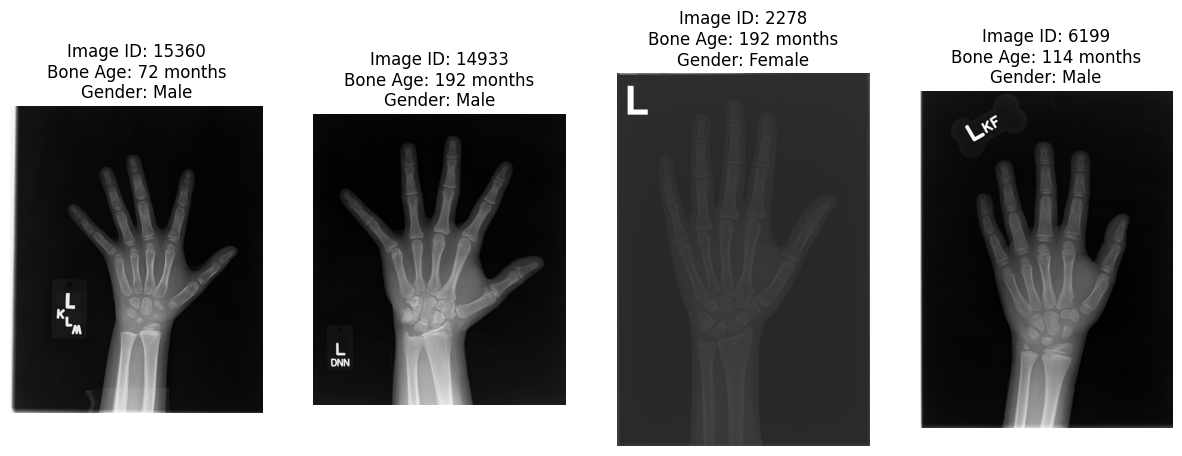

Sample images from validation dataset:


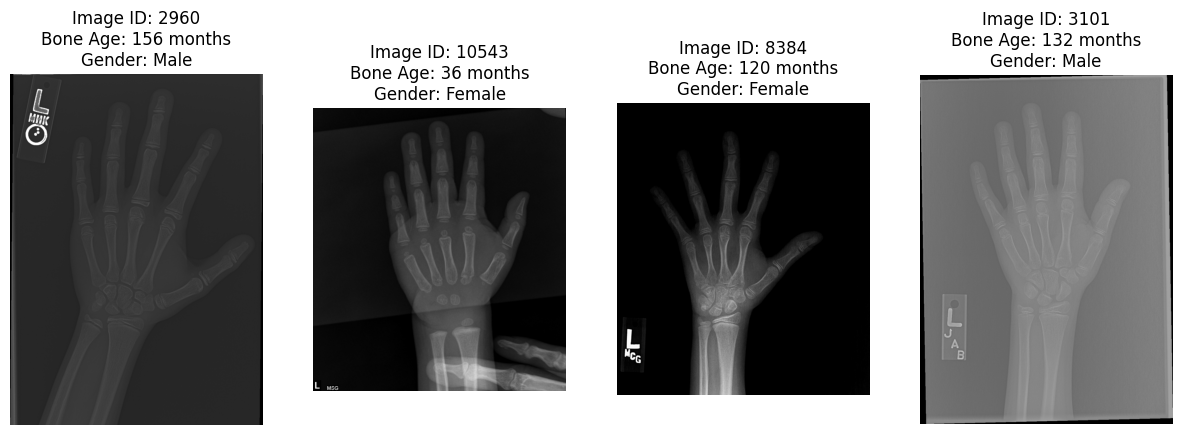

Sample images from test dataset:


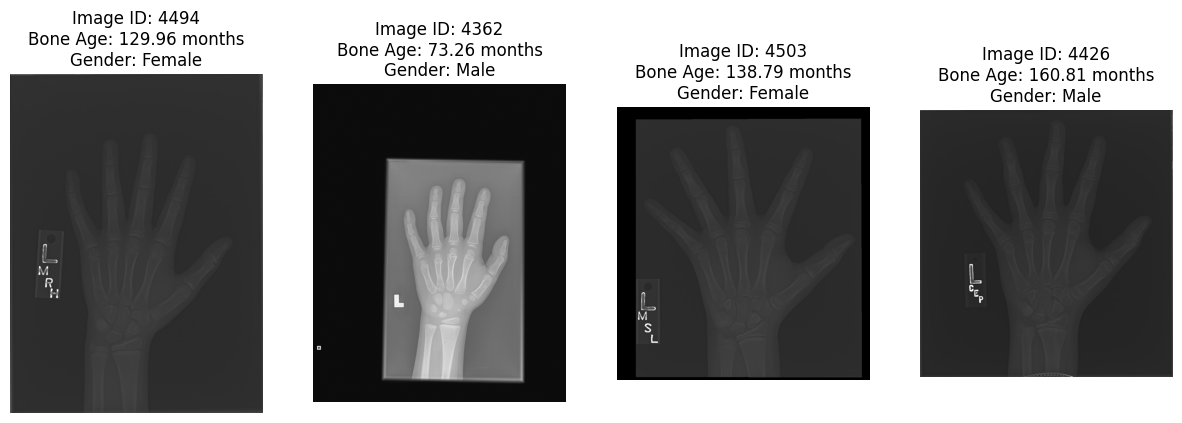

In [ ]:
# Display sample images from the train, validation and test datasets
print("Sample images from training dataset:")
display_sample_images(train_metadata, train_image_dir)

print("Sample images from validation dataset:")
display_sample_images(val_metadata, val_image_dir)

print("Sample images from test dataset:")
display_sample_images(test_metadata, test_image_dir)


In [ ]:
# Plot distributions for train, validation and test datasets
print("Distribution plots for training dataset:")
plot_distributions(train_metadata)

print("Distribution plots for validation dataset:")
plot_distributions(val_metadata)

print("Distribution plots for test dataset:")
plot_distributions(test_metadata)

In [ ]:
# Display sample Raw vs. CLAHE enhanced images from the train dataset
print("Sample Raw vs. CLAHE enhanced images from training dataset:")
display_raw_vs_clahe_images(train_metadata, train_image_dir)

# Models

In [ ]:
# Initialize dicts to store performance metrics and training history for all models
model_results_dict = {}
model_metrics_dict = {}


## 1) Global CNN





### Datasets


In [ ]:
# Train dataset
train_ds = make_dataset(train_image_dir, train_metadata, image_size=256, clahe=True)
train_ds = train_ds.map(
    lambda features, age: ({"image": features["image"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.batch(16)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset
val_ds = make_dataset(val_image_dir, val_metadata, image_size=256, clahe=True)
val_ds = val_ds.map(
    lambda features, age: ({"image": features["image"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
val_ds = val_ds.batch(16)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test dataset
test_ds = make_dataset(test_image_dir, test_metadata, image_size=256, clahe=True)
test_ds = test_ds.map(
    lambda features, age: ({"image": features["image"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
test_ds = test_ds.batch(16)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


### 1.1) Global CNN Model w/o Gender

In [ ]:
# Build Model
model_GlobalCNN = build_GlobalCNN(
    input_shape=(256, 256, 1),
    channels=(32, 64, 128),
    dense_units=64,
    dropout_rate=0.2,
    use_gender=False,
)

# Compile Model
model_GlobalCNN.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=losses.Huber(delta=10, name="huber"),
    metrics=[metrics.MeanAbsoluteError(name="mae"),
             metrics.RootMeanSquaredError(name="rmse")]
)

#### 1.1.1) Train

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_mae", patience=10,
                                     verbose=1, mode="min",
                                     restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.1,
                                        patience=4, min_lr=1e-5, verbose=1)

start_train = time.time()
history_GlobalCNN = model_GlobalCNN.fit(
    train_ds,
    validation_data=val_ds,
    epochs=70,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)
end_train = time.time()

num_params = int(model_GlobalCNN.count_params())
training_time = end_train - start_train
num_epochs_ran = len(history_GlobalCNN.history.get("loss", []))
best_epoch_idx = history_GlobalCNN.history["val_mae"].index(min(history_GlobalCNN.history["val_mae"]))

model_results_dict["GlobalCNN"] = {
    "num_params": num_params,
    "training_time": training_time,
    "num_epochs_ran": num_epochs_ran,
    "best_epoch_idx": best_epoch_idx+1
}


#### 1.1.2) Model Architecture

In [ ]:
model_GlobalCNN.summary()

In [ ]:
keras.utils.plot_model(model_GlobalCNN, show_shapes=True, show_layer_names=True)

#### 1.1.3) Test

In [ ]:
test_metrics_GlobalCNN = model_GlobalCNN.evaluate(test_ds, return_dict=True, verbose=1)

#### 1.1.4) Performance Metrics

In [ ]:
model_metrics_dict["GlobalCNN"] = {
    "history": history_GlobalCNN.history,
    "train_loss": history_GlobalCNN.history["loss"][best_epoch_idx],
    "train_mae": history_GlobalCNN.history["mae"][best_epoch_idx],
    "train_rmse": history_GlobalCNN.history["rmse"][best_epoch_idx],
    "val_loss": history_GlobalCNN.history["val_loss"][best_epoch_idx],
    "val_mae": history_GlobalCNN.history["val_mae"][best_epoch_idx],
    "val_rmse": history_GlobalCNN.history["val_rmse"][best_epoch_idx],
    "test_loss": test_metrics_GlobalCNN["loss"],
    "test_mae": test_metrics_GlobalCNN["mae"],
    "test_rmse": test_metrics_GlobalCNN["rmse"]
}

In [ ]:
plot_training_metrics(model_metrics_dict["GlobalCNN"], "GlobalCNN")

### 1.2) Global CNN Model with Gender

In [ ]:
# Build Model
model_GlobalCNN_Gender = build_GlobalCNN(
    input_shape=(256, 256, 1),
    channels=(32, 64, 128),
    dense_units=64,
    dropout_rate=0.2,
    use_gender=True,
)

# Compile Model
model_GlobalCNN_Gender.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=losses.Huber(delta=10, name="huber"),
    metrics=[metrics.MeanAbsoluteError(name="mae"),
             metrics.RootMeanSquaredError(name="rmse")]
)

#### 1.2.1) Train

In [ ]:
start_train = time.time()
history_GlobalCNN_Gender = model_GlobalCNN_Gender.fit(
    train_ds,
    validation_data=val_ds,
    epochs=70,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)
end_train = time.time()

num_params = int(model_GlobalCNN_Gender.count_params())
training_time = end_train - start_train
num_epochs_ran = len(history_GlobalCNN_Gender.history.get("loss", []))
best_epoch_idx = history_GlobalCNN_Gender.history["val_mae"].index(min(history_GlobalCNN_Gender.history["val_mae"]))

model_results_dict["GlobalCNN_Gender"] = {
    "num_params": num_params,
    "training_time": training_time,
    "num_epochs_ran": num_epochs_ran,
    "best_epoch_idx": best_epoch_idx+1
}


#### 1.2.2) Model Architecture

In [ ]:
model_GlobalCNN_Gender.summary()

In [ ]:
keras.utils.plot_model(model_GlobalCNN_Gender, show_shapes=True, show_layer_names=True)

#### 1.2.3) Test

In [ ]:
test_metrics_GlobalCNN_Gender = model_GlobalCNN_Gender.evaluate(test_ds, return_dict=True, verbose=1)

#### 1.2.4) Performance Metrics

In [ ]:
model_metrics_dict["GlobalCNN_Gender"] = {
    "history": history_GlobalCNN_Gender.history,
    "train_loss": history_GlobalCNN_Gender.history["loss"][best_epoch_idx],
    "train_mae": history_GlobalCNN_Gender.history["mae"][best_epoch_idx],
    "train_rmse": history_GlobalCNN_Gender.history["rmse"][best_epoch_idx],
    "val_loss": history_GlobalCNN_Gender.history["val_loss"][best_epoch_idx],
    "val_mae": history_GlobalCNN_Gender.history["val_mae"][best_epoch_idx],
    "val_rmse": history_GlobalCNN_Gender.history["val_rmse"][best_epoch_idx],
    "test_loss": test_metrics_GlobalCNN_Gender["loss"],
    "test_mae": test_metrics_GlobalCNN_Gender["mae"],
    "test_rmse": test_metrics_GlobalCNN_Gender["rmse"]
}

In [ ]:
plot_training_metrics(model_metrics_dict["GlobalCNN_Gender"], "GlobalCNN_Gender")

## 2) ROI CNN





### ROI Location & Extraction

In [ ]:
def train_locator_and_save_rois(ds:tf.data.Dataset, roi_paths: dict, split: str):
  os.makedirs(roi_paths["carpal"], exist_ok=True)
  os.makedirs(roi_paths["metaph"], exist_ok=True)
  os.makedirs(roi_paths["heatmaps"], exist_ok=True)

  # --- Iterate once over split, save crops
  for features, _ in ds:
    image = features["image"]
    image_id = features["image_id"]

    # Compute Grad-CAM on the locator
    cam = compute_GradCAM(model=model_GlobalCNN, image=image)

    # Extract ROIs from the heatmap
    rois = extract_rois_from_heatmap(
        heatmap=cam,
        image=image,
        roi_size=128,
        carpal_margin=0.48, # extra border around peak box (fraction of shorter side)
        meta_mask_radius=0.35, # mask radius (fraction of shorter side) to hide carpal when finding metacarpal
        heatmap_threshold=0.25,
    )

    img_id = image_id.numpy().decode("utf-8")
    overlay_rgb = overlay_cam_on_image(gray_img=image, cam=cam)

    # Save crops as {image_id}.png
    for key in roi_paths.keys():
      if key == "heatmaps":
        x = tf.convert_to_tensor(overlay_rgb)
      else:
        x = tf.convert_to_tensor(rois[key])
      if x.dtype != tf.uint8:
        if x.dtype.is_floating:
          x = tf.clip_by_value(x, 0.0, 1.0)
          x = tf.image.convert_image_dtype(x, dtype=tf.uint8)
        else:
          x = tf.cast(x, tf.uint8)
      path = os.path.join(roi_paths[key], f"{img_id}.png")
      tf.io.write_file(path, tf.io.encode_png(x))


In [ ]:
roi_path = "data/cropped_rois"
if not os.path.exists(roi_path):
  os.makedirs(roi_path)
def has_pngs(path: str) -> bool:
  return os.path.isdir(path) and glob.glob(os.path.join(path, "*.png"))

# Generate crops for each split (train/val/test) if not already present
roi_extraction_time = 0.0
roi_paths = {}
for split in ["train", "validation", "test"]:
  carpal_dir = os.path.join(roi_path, split, "carpal")
  metaph_dir = os.path.join(roi_path, split, "metaph")
  heatmaps_dir = os.path.join(roi_path, split, "heatmaps")
  roi_paths[split] = {
      "carpal": carpal_dir,
      "metaph": metaph_dir,
      "heatmaps": heatmaps_dir
  }
  if not (has_pngs(carpal_dir) and has_pngs(metaph_dir)):
    roi_time_start = time.time()
    if split == "train": ds = train_ds
    elif split == "validation": ds = val_ds
    elif split == "test": ds = test_ds
    train_locator_and_save_rois(ds, roi_paths=roi_paths[split], split=split)
    roi_time_end = time.time()
    roi_extraction_time += roi_time_end - roi_time_start

### ROI Datasets


In [ ]:
# Train dataset
train_ds_roi = make_roi_dataset(roi_paths["train"], train_metadata)
train_ds_roi = train_ds_roi.map(
    lambda features, age: ({"carpal": features["carpal"],
                            "metaph": features["metaph"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds_roi = train_ds_roi.batch(16)
train_ds_roi = train_ds_roi.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset
val_ds_roi = make_roi_dataset(roi_paths["validation"], val_metadata)
val_ds_roi = val_ds_roi.map(
    lambda features, age: ({"carpal": features["carpal"],
                            "metaph": features["metaph"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
val_ds_roi = val_ds_roi.batch(16)
val_ds_roi = val_ds_roi.prefetch(buffer_size=tf.data.AUTOTUNE)

# Test dataset
test_ds_roi = make_roi_dataset(test_image_dir, test_metadata, image_size=256, clahe=True)
test_ds_roi = test_ds_roi.map(
    lambda features, age: ({"carpal": features["carpal"],
                            "metaph": features["metaph"],
                            "gender": tf.cast(features["gender"], tf.int32)}, age),
    num_parallel_calls=tf.data.AUTOTUNE,
)
test_ds_roi = test_ds_roi.batch(16)
test_ds_roi = test_ds_roi.prefetch(buffer_size=tf.data.AUTOTUNE)


### 2.1) ROI CNN Model w/o Gender

In [ ]:
# Build Model
model_ROI_CNN = build_ROI_CNN(
    roi_shape=(128, 128, 1),
    channels=(32, 64, 128),
    dense_units=64,
    dropout_rate=0.2,
    use_gender=False,
)

# Compile Model
model_ROI_CNN.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss=losses.Huber(delta=10, name="huber"),
    metrics=[metrics.MeanAbsoluteError(name="mae"),
             metrics.RootMeanSquaredError(name="rmse")]
)

#### 2.1.1) Train

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor="val_mae", patience=10,
                                     verbose=1, mode="min",
                                     restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.25,
                                        patience=4, min_lr=1e-6, verbose=1)

start_train = time.time()
history_ROI_CNN = model_ROI_CNN.fit(
    train_ds_roi,
    validation_data=val_ds_roi,
    epochs=70,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)
end_train = time.time()

num_params = int(model_ROI_CNN.count_params())
training_time = end_train - start_train
num_epochs_ran = len(history_ROI_CNN.history.get("loss", []))
best_epoch_idx = history_ROI_CNN.history["val_mae"].index(min(history_ROI_CNN.history["val_mae"]))

model_results_dict["ROI_CNN"] = {
    "num_params": num_params,
    "training_time": training_time,
    "num_epochs_ran": num_epochs_ran,
    "best_epoch_idx": best_epoch_idx+1
}


#### 2.1.2) Model Architecture

In [ ]:
model_ROI_CNN.summary()

In [ ]:
keras.utils.plot_model(model_ROI_CNN, show_shapes=True, show_layer_names=True)

#### 2.1.3) Test

In [ ]:
test_metrics_ROI_CNN = model_ROI_CNN.evaluate(test_ds_roi, return_dict=True, verbose=1)

#### 2.1.4) Performance Metrics

In [ ]:
model_metrics_dict["ROI_CNN"] = {
    "history": history_ROI_CNN.history,
    "train_loss": history_ROI_CNN.history["loss"][best_epoch_idx],
    "train_mae": history_ROI_CNN.history["mae"][best_epoch_idx],
    "train_rmse": history_ROI_CNN.history["rmse"][best_epoch_idx],
    "val_loss": history_ROI_CNN.history["val_loss"][best_epoch_idx],
    "val_mae": history_ROI_CNN.history["val_mae"][best_epoch_idx],
    "val_rmse": history_ROI_CNN.history["val_rmse"][best_epoch_idx],
    "test_loss": test_metrics_ROI_CNN["loss"],
    "test_mae": test_metrics_ROI_CNN["mae"],
    "test_rmse": test_metrics_ROI_CNN["rmse"]
}

In [ ]:
plot_training_metrics(model_metrics_dict["ROI_CNN"], "ROI_CNN")

### 2.2) ROI CNN Model with Gender

In [ ]:
# Build Model
model_ROI_CNN_Gender = build_ROI_CNN_Gender(
    roi_shape=(128, 128, 1),
    channels=(32, 64, 128),
    dense_units=64,
    dropout_rate=0.2,
    use_gender=False,
)

# Compile Model
model_ROI_CNN_Gender.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss=losses.Huber(delta=10, name="huber"),
    metrics=[metrics.MeanAbsoluteError(name="mae"),
             metrics.RootMeanSquaredError(name="rmse")]
)

#### 2.2.1) Train

In [ ]:
start_train = time.time()
history_ROI_CNN_Gender = model_ROI_CNN_Gender.fit(
    train_ds_roi,
    validation_data=val_ds_roi,
    epochs=70,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)
end_train = time.time()

num_params = int(model_ROI_CNN_Gender.count_params())
training_time = end_train - start_train
num_epochs_ran = len(history_ROI_CNN_Gender.history.get("loss", []))
best_epoch_idx = history_ROI_CNN_Gender.history["val_mae"].index(min(history_ROI_CNN_Gender.history["val_mae"]))

model_results_dict["ROI_CNN_Gender"] = {
    "num_params": num_params,
    "training_time": training_time,
    "num_epochs_ran": num_epochs_ran,
    "best_epoch_idx": best_epoch_idx+1
}


#### 2.2.2) Model Architecture

In [ ]:
model_ROI_CNN_Gender.summary()

In [ ]:
keras.utils.plot_model(model_ROI_CNN_Gender, show_shapes=True, show_layer_names=True)

#### 2.2.3) Test

In [ ]:
test_metrics_ROI_CNN_Gender = model_ROI_CNN_Gender.evaluate(test_ds_roi, return_dict=True, verbose=1)

#### 2.2.4) Performance Metrics

In [ ]:
model_metrics_dict["ROI_CNN_Gender"] = {
    "history": history_ROI_CNN_Gender.history,
    "train_loss": history_ROI_CNN_Gender.history["loss"][best_epoch_idx],
    "train_mae": history_ROI_CNN_Gender.history["mae"][best_epoch_idx],
    "train_rmse": history_ROI_CNN_Gender.history["rmse"][best_epoch_idx],
    "val_loss": history_ROI_CNN_Gender.history["val_loss"][best_epoch_idx],
    "val_mae": history_ROI_CNN_Gender.history["val_mae"][best_epoch_idx],
    "val_rmse": history_ROI_CNN_Gender.history["val_rmse"][best_epoch_idx],
    "test_loss": test_metrics_ROI_CNN_Gender["loss"],
    "test_mae": test_metrics_ROI_CNN_Gender["mae"],
    "test_rmse": test_metrics_ROI_CNN_Gender["rmse"]
}

In [ ]:
plot_training_metrics(model_metrics_dict["ROI_CNN_Gender"], "ROI_CNN_Gender")